### Learning ML with Scikit

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from utils import outlier as ot
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
df = pd.read_csv("..\miq-training-data\ml-data\House_Rent_Dataset.csv", parse_dates=["Posted On"])

df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [3]:
df["Rental Floor"] = df["Floor"].apply(lambda x: x.split(" out of ")[0])
df["Total Number of Floor"] = df["Floor"].apply(lambda x: x.split(" out of ")[-1])

df.sample(5)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor
2115,2022-06-27,3,32000,1768,8 out of 13,Super Area,Yelahanka,Bangalore,Semi-Furnished,Family,3,Contact Agent,8,13
3761,2022-06-25,1,10000,600,4 out of 5,Super Area,Mugalivakkam,Chennai,Unfurnished,Bachelors/Family,1,Contact Owner,4,5
518,2022-06-08,2,45000,1320,Lower Basement out of 2,Super Area,Ballygunge,Kolkata,Furnished,Bachelors/Family,2,Contact Owner,Lower Basement,2
829,2022-07-09,3,130000,1450,9 out of 10,Carpet Area,Santacruz East,Mumbai,Semi-Furnished,Bachelors/Family,5,Contact Agent,9,10
4192,2022-07-06,2,12333,1200,Ground out of 1,Super Area,Alwal,Hyderabad,Unfurnished,Bachelors/Family,2,Contact Owner,Ground,1


In [4]:
df["Rental Floor"].unique()

array(['Ground', '1', '2', '4', '3', '5', '7', '8', 'Upper Basement',
       '11', 'Lower Basement', '6', '14', '43', '13', '18', '17', '9',
       '19', '60', '34', '12', '26', '25', '53', '16', '10', '39', '32',
       '47', '28', '20', '15', '65', '40', '37', '22', '21', '30', '35',
       '33', '44', '41', '46', '27', '45', '48', '50', '24', '23', '29',
       '49', '36', '76'], dtype=object)

In [5]:
df["Total Number of Floor"].unique()


array(['2', '3', '1', '4', '5', '14', '8', '6', '19', '10', '7', '13',
       '78', '18', '12', '24', '31', '21', '23', '20', '9', '22', '58',
       '16', '66', '48', '40', '44', '42', '41', '60', '32', '30', '29',
       '89', '15', '11', '28', '17', '45', '35', '75', '38', '51', '43',
       '25', '27', '26', '76', '36', '37', '55', '68', '77', '50', '59',
       '62', '39', '52', '54', '33', '46', '85', '71', '81', '34',
       'Ground'], dtype=object)

In [6]:
df["Rental Floor"] = df["Rental Floor"].replace(["Ground", "Upper Basement", "Lower Basement"], [0, -1, -2]).astype(int)
df["Total Number of Floor"] = df["Total Number of Floor"].replace("Ground", 0).astype(int)

df.drop(columns="Floor", inplace=True)
df.sample()


,Posted On,BHK,Rent,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor
2002,2022-06-20,2,12500,800,Super Area,Nagondanahalli,Bangalore,Furnished,Bachelors/Family,2,Contact Owner,2,3


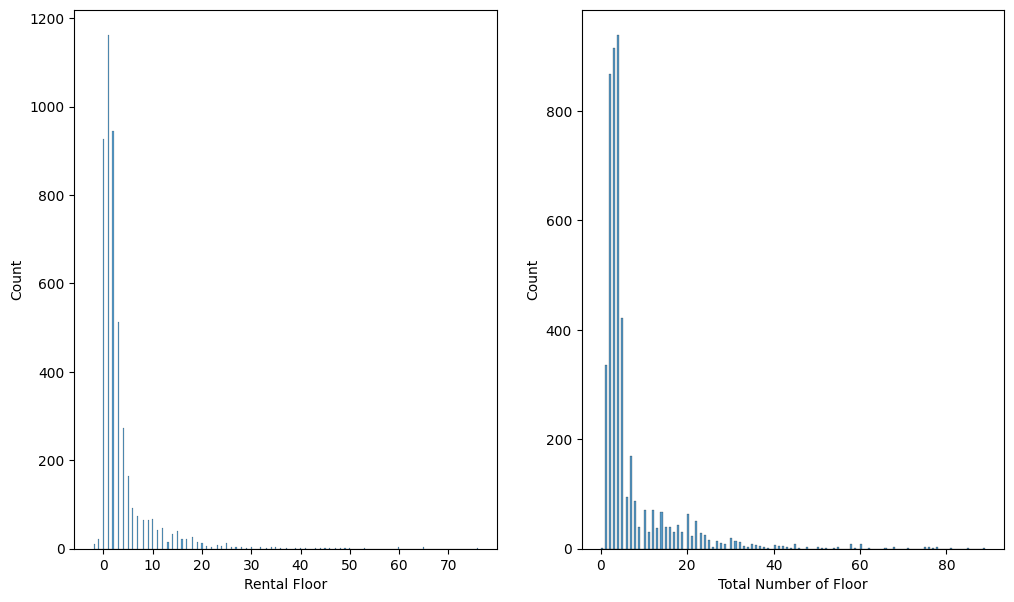

In [7]:
num_var = ["Rental Floor", "Total Number of Floor"]
fig, axes = plt.subplots(1, 2, figsize=(12,7))

for num, ax in zip(num_var, axes.flatten()):
    sns.histplot(x=num, data=df, ax=ax)

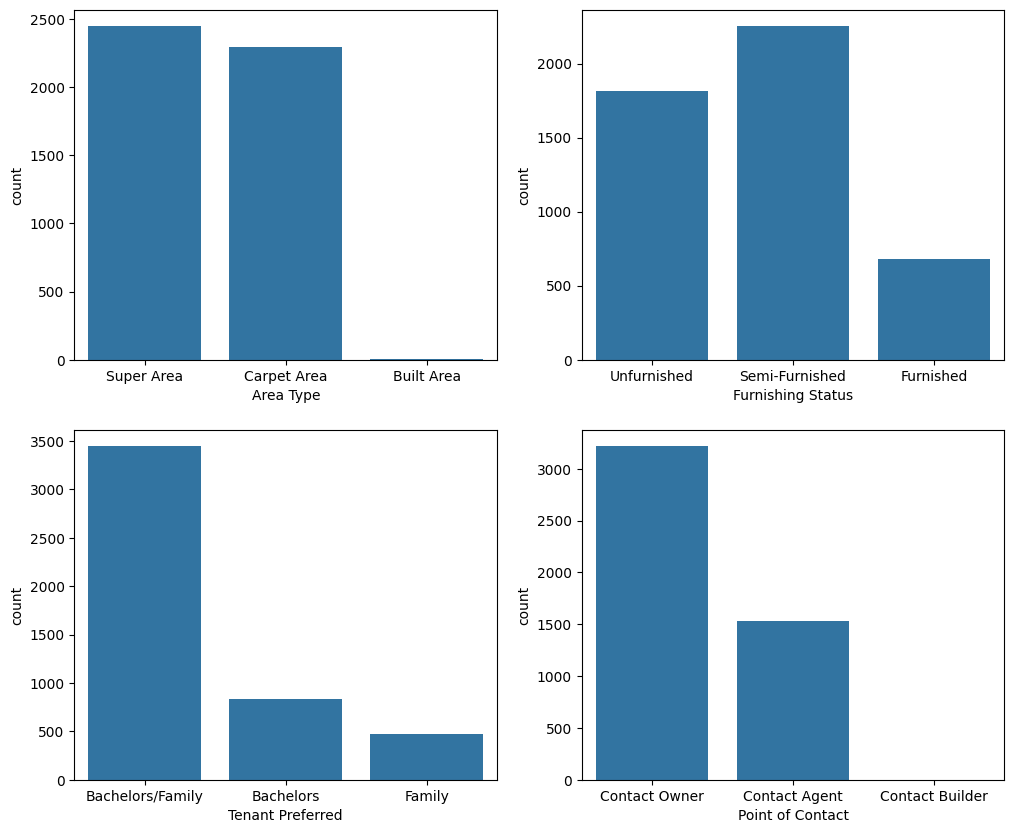

In [8]:
cat_var = ["Area Type", "Furnishing Status", "Tenant Preferred", "Point of Contact"]
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(x=cat, data=df, ax=ax)
    
    

In [9]:
df.replace(to_replace=["Built Area", "Contact Builder"], 
           value=["Super Area", "Contact Owner"], inplace=True)
           
           
area_mean = df.query("BHK + Bathroom == 4").groupby("Area Type", as_index=False).mean(numeric_only=True)
area_mean

,Area Type,BHK,Rent,Size,Bathroom,Rental Floor,Total Number of Floor
0,Carpet Area,2.012484,34236.268414,838.001248,1.987516,4.308365,8.796504
1,Super Area,2.017787,15827.197628,933.087945,1.982213,1.777668,3.970356


In [10]:

carpet_area_size = area_mean.loc[0, "Size"]
super_area_size = area_mean.loc[1, "Size"]
area_per_multi = (super_area_size - carpet_area_size) / carpet_area_size + 1 #area prcentage multiplier
area_per_multi

1.1134684422029848

In [11]:
fixed_size = df.query("`Area Type` == 'Carpet Area'")["Size"].apply(lambda x: x * area_per_multi)
df["Fixed Size"] = np.round(fixed_size, 2)
df["Fixed Size"].fillna(df["Size"], inplace=True)
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11828\2787545805.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Fixed Size"].fillna(df["Size"], inplace=True)


,Posted On,BHK,Rent,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size
0,2022-05-18,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,1100.00
1,2022-05-13,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,800.00
2,2022-05-16,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,1000.00
3,2022-07-04,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2,800.00
4,2022-05-09,2,7500,850,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2,946.45


In [12]:
df.drop(columns=["Area Locality", "Posted On"], inplace=True)


In [13]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'xy'}]])

fig.add_trace(go.Pie(labels = df["Point of Contact"] ,name="Point of Contact", textinfo='percent+label', textposition='inside', marker=dict(line=dict(color='white', width=1))),row=1, col=1)
fig.add_trace(go.Histogram(x = df["Point of Contact"],name="Point of Contact"),row=1, col=2)

fig.update_layout(showlegend=False, title="Point of Contact", title_x=.5)

fig.show()


In [14]:

fig = go.Figure()
fig.add_trace(go.Histogram(x = df["City"], name="City", texttemplate="%{y}")).update_xaxes(categoryorder='total descending')
fig.update_layout(title="Total Number of Rental Houses in Cities", title_x=.5)
fig.show()


In [15]:

square_feet_rent = df["Rent"]/df["Fixed Size"]
df["Square Feet Rent"] = np.round(square_feet_rent, 2)
df.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size,Square Feet Rent
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,1100.00,9.09
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,800.00,25.00
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,1000.00,17.00
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2,800.00,12.50
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2,946.45,7.92


In [16]:
fig = px.box(df, x="Square Feet Rent", color="City")
fig.show()


In [17]:
index = ot.outlier_detect_MAD(data=df, col="Square Feet Rent", threshold=3.5)


Num of outlier detected: 827
Proportion of outlier detected 17.43%


c:\demonstrations\ml-dl\notebooks\utils\outlier.py:85: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\demonstrations\ml-dl\notebooks\utils\outlier.py:86: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [18]:
df.loc[index, "Square Feet Rent"].sort_values()


1368      57.94
756       58.03
968       58.10
1117      58.11
1213      58.11
         ...   
3922     826.15
2656     853.20
4004    1000.00
1837    1257.33
4653    1347.71
Name: Square Feet Rent, Length: 827, dtype: float64

In [19]:
df = df.drop(df.query("`Square Feet Rent` > 57.94").index)


In [20]:
df.drop(columns = ["Size", "Area Type"], inplace = True)


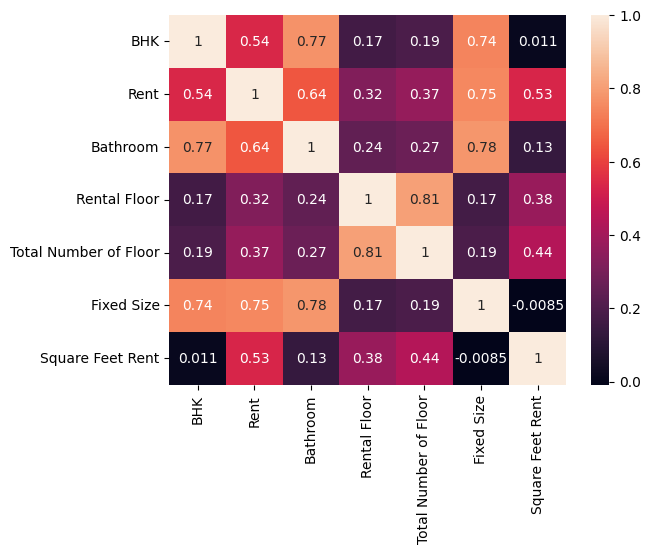

In [21]:
sns.heatmap(df.corr(numeric_only=True), annot=True,);


In [22]:


X = df.drop(columns='Rent')
y = df['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=101)
X_train.shape, X_test.shape





((2940, 10), (980, 10))

In [23]:
X_train.head()

,BHK,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size,Square Feet Rent
2573,3,Delhi,Semi-Furnished,Bachelors,3,Contact Agent,1,1,1892.90,27.47
443,2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,2,556.73,10.78
1107,1,Mumbai,Semi-Furnished,Bachelors/Family,1,Contact Agent,0,7,367.44,46.27
1919,1,Bangalore,Unfurnished,Bachelors/Family,1,Contact Owner,3,3,334.04,20.96
332,1,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,1,400.00,16.25


In [24]:
cat_pipe = Pipeline([("encode", OneHotEncoder(handle_unknown="ignore"))])
num_pipe = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer([
    ("numeric", num_pipe, [0,4,6,7,8,9]),
    ("categoric", cat_pipe, [1,2,3,5])
])

pipeline_xgbr = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor())
])

pipeline_xgbr.fit(X_train,y_train)
y_pred = pipeline_xgbr.predict(X_test)
print(f"Score    : {r2_score(y_test, y_pred)}")
print(f"mae      : {mean_absolute_error(y_test, y_pred)}")
print(f"root mse : {np.sqrt(mean_squared_error(y_test, y_pred))}")



Score    : 0.9785805940628052
mae      : 800.0709126375159
root mse : 3173.913773458429


In [25]:
cat_pipe = Pipeline([("encode", OneHotEncoder(handle_unknown="ignore"))])
num_pipe = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer([
    ("numeric", num_pipe, [0,4,6,7,8,9]),
    ("categoric", cat_pipe, [1,2,3,5])
])

pipeline_lgbm = Pipeline([
    ('prep', preprocessor),
    ('algo', LGBMRegressor())
])

pipeline_lgbm.fit(X_train,y_train)
y_pred = pipeline_lgbm.predict(X_test)
print(f"Score    : {r2_score(y_test, y_pred)}")
print(f"mae      : {mean_absolute_error(y_test, y_pred)}")
print(f"root mse : {np.sqrt(mean_squared_error(y_test, y_pred))}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 2940, number of used features: 20
[LightGBM] [Info] Start training from score 20943.766667
Score    : 0.9862029550152648
mae      : 662.0601750381039
root mse : 2547.3245339839686


In [26]:
from jcopml.tuning.space import Integer, Real


params = {'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}
 

In [27]:
cat_pipe = Pipeline([("encode", OneHotEncoder(handle_unknown="ignore"))])
num_pipe = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer([
    ("numeric", num_pipe, [0,4,6,7,8,9]),
    ("categoric", cat_pipe, [1,2,3,5])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor())
])
    
model = RandomizedSearchCV(pipeline, params, cv=3, n_iter=50, n_jobs=1, verbose=1, random_state=101)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(f"Score    : {r2_score(y_test, y_pred)}")
print(f"mae      : {mean_absolute_error(y_test, y_pred)}")
print(f"root mse : {np.sqrt(mean_squared_error(y_test, y_pred))}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Score    : 0.9788652062416077
mae      : 755.2252279476244
root mse : 3152.7559226095273


In [29]:
X_train.head(2)





,BHK,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size,Square Feet Rent
2573,3,Delhi,Semi-Furnished,Bachelors,3,Contact Agent,1,1,1892.90,27.47
443,2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,2,556.73,10.78


In [30]:
y_train.head(2)

2573    52000
443      6000
Name: Rent, dtype: int64

In [31]:
columns = X_train.columns

data = [[2, "Hyderabad", "Unfurnished", "Bachelors/Family", 2, "Contact Owner", 4, 12, 1000.0, 12.25]]
data = pd.DataFrame(data=data, columns=columns)

pred = pipeline_lgbm.predict(data)
pred

array([12180.53826797])

In [32]:
import pickle

TARGET_MODEL_FILE = "./lgbm_model.pkl"

with open(TARGET_MODEL_FILE, "wb") as f:
    pickle.dump(pipeline_lgbm, f)
    